# Lesson 10 - Sentiment Analysis
## Author - Ana Javed 

This assignment requires that you build a sentiment analysis classifier for a series of tweets.
The data consists of a file "twitter_data.csv". The file contains 16,000 tweets with their respective score. The attributes are the sentences, and the score is either 4 (for positive) or 0 (for negative).

Assignment Instructions
1. Complete all questions below.
2. Comment on the applicability of the model on future tweets.  

In [46]:
#Imports
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import csv
import lda
import editdistance
import string
import re
import nltk
from wordcloud import WordCloud

# Specialty libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from scipy.sparse import coo_matrix
from collections import Counter
import argparse
import pprint
import gensim


In [47]:
#Read files
url = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/twitter_data.csv"
df = pd.read_csv(url, sep=",")
df.columns = ["sentiment_label","tweet_text"]
    
print(df.head())


   sentiment_label                                         tweet_text
0                4  @elephantbird Hey dear, Happy Friday to You  A...
1                4  Ughhh layin downnnn    Waiting for zeina to co...
2                0  @greeniebach I reckon he'll play, even if he's...
3                0              @vaLewee I know!  Saw it on the news!
4                0  very sad that http://www.fabchannel.com/ has c...


In [48]:
## Importing Stop Words, WordNet 
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anajaved/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anajaved/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
# Creating a function to do Cleaning on the Dataset 
def preprocess(text, list_of_steps):
    
    for step in list_of_steps:
        if step == 'remove_non_ascii':
            text = ''.join([x for x in text if ord(x) < 128])
        elif step == 'lowercase':
            text = text.lower()
        elif step == 'remove_punctuation':
            punct_exclude = set(string.punctuation)
            text = ''.join(char for char in text if char not in punct_exclude)
        elif step == 'remove_numbers':
            text = re.sub("\d+", "", text)
        elif step == 'strip_whitespace':
            text = ' '.join(text.split())
        elif step == 'remove_stopwords':
            stops = stopwords.words('english')
            word_list = text.split(' ')
            text_words = [word for word in word_list if word not in stops]
            text = ' '.join(text_words)
        elif step == 'stem_words':
            lmtzr = WordNetLemmatizer()
            word_list = text.split(' ')
            stemmed_words = [lmtzr.lemmatize(word) for word in word_list]
            text = ' '.join(stemmed_words)
    return text


In [50]:
# Cleaning all tweets 
steps = ['lowercase', 'remove_punctuation', 'remove_numbers', 'strip_whitespace']

df['clean_tweet'] = df['tweet_text'].map(lambda s: preprocess(s, steps))

In [53]:
# Change Sentiment to '1' or '0' to indicate positive or negative sentiment.
df.sentiment_label = df.sentiment_label.replace(4,1)
df.head()

,sentiment_label,tweet_text,clean_tweet
0,1,"@elephantbird Hey dear, Happy Friday to You A...",elephantbird hey dear happy friday to you alre...
1,1,Ughhh layin downnnn Waiting for zeina to co...,ughhh layin downnnn waiting for zeina to cook ...
2,0,"@greeniebach I reckon he'll play, even if he's...",greeniebach i reckon hell play even if hes not...
3,0,@vaLewee I know! Saw it on the news!,valewee i know saw it on the news
4,0,very sad that http://www.fabchannel.com/ has c...,very sad that httpwwwfabchannelcom has closed ...


In [69]:
## Separating Out Positive/Negative Sentiment Tweets

pos_df = df.loc[df.loc[: , "sentiment_label"] == 1, "clean_tweet"]
neg_df = df.loc[df.loc[: , "sentiment_label"] == 0 ,  "clean_tweet"]

## Positive Df
print(pos_df.shape)
print(pos_df.head())

## Negative
print(neg_df.shape)
print(neg_df.head())

# Convert a copy of the tweets as list for use later
pos_tweet_data = pos_df.values.tolist()
neg_tweet_data = neg_df.values.tolist()


(80000,)
0     elephantbird hey dear happy friday to you alre...
1     ughhh layin downnnn waiting for zeina to cook ...
6              with god on ur side anything is possible
10    the video on vh is much better than the u tube...
14    ashleyltmsyf hey ashley when will the hush hus...
Name: clean_tweet, dtype: object
(80000,)
2    greeniebach i reckon hell play even if hes not...
3                    valewee i know saw it on the news
4    very sad that httpwwwfabchannelcom has closed ...
5    fearnecotton who sings i remember i alwaysss h...
7                            lovesmrs why being stupid
Name: clean_tweet, dtype: object


In [74]:
# Function to convert Lists to String 
def listToString(s):  
    str1 = ""  
    
    for ele in s:  
        str1 += ele   

    return str1  

pos_tweet_data = listToString(pos_tweet_data)
neg_tweet_data = listToString(neg_tweet_data)

### Q1: Generate word cloud for positive sentiment.

(-0.5, 799.5, 399.5, -0.5)

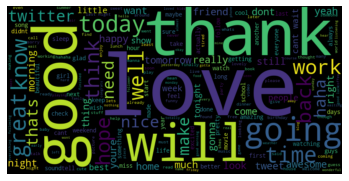

In [88]:
# Generate a word cloud image
clean_pos_tweets = WordCloud(min_word_length=4).process_text(pos_tweet_data)
wordcloud = WordCloud(min_word_length=4).generate_from_frequencies(clean_pos_tweets)

# Display the generated the matplotlib image:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### Q2: Generate word cloud for negative sentiment.

(-0.5, 799.5, 399.5, -0.5)

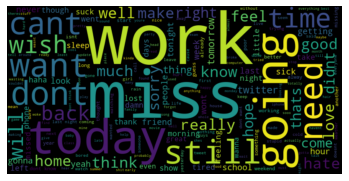

In [89]:
# Generating a Negative a word cloud image
clean_neg_tweets = WordCloud(min_word_length=4).process_text(neg_tweet_data)
wordcloud = WordCloud(min_word_length=4).generate_from_frequencies(clean_neg_tweets)

# Display the generated the matplotlib image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### Q3: Split data into 70% for training and 30% for testing.

In [92]:
# Declare the TFIDF vectorizer.
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, 
                             max_features=6228, stop_words='english')

# Fit the vectorizer over the dataset
clean_texts = df['clean_tweet']
tf_idf_tweets = vectorizer.fit_transform(clean_texts)

In [114]:
print('Splitting into train-test')

# Importing Sklearn Function to split test and training data 
from sklearn.model_selection import train_test_split

# Separating out the Sentiment Targets 
y_targets = np.array(df.loc[:, "sentiment_label"])

# Separating the Training (70%) and Testing (30%) Datasets 
X_train, X_test, y_train, y_test = train_test_split(tf_idf_tweets,
                                                    y_targets,
                                                    test_size = 0.3, 
                                                    train_size = 0.7,
                                                    random_state= 50)
print('Done!')


Splitting into train-test
Done!


### Q4: Build a classifier that classifies the sentiment of a sentence.

In [115]:
print('Starting a standard Logistic Model training!')
## Importing Logistic Regression from Sklearn 
from sklearn.linear_model import LogisticRegression

## Calling and Fitting Logistic Regression Model with Training Dataset 
lr = LogisticRegression()
lr.fit(X_train, y_train)


print('Done.')

Starting a standard Logistic Model training!
Done.


### Q5: What is the accuracy of your model when applied to testing data?

In [104]:
## Compute results on the train and test set
train_probs = lr.predict_proba(X_train)
train_results = np.argmax(train_probs, axis=1)

test_probs = lr.predict_proba(X_test)
test_results = np.argmax(test_probs, axis=1)

In [106]:
# Compute accuracies
train_logical_correct = [pred == actual for pred, actual in 
                         zip(train_results, y_train)]
train_acc = np.mean(train_logical_correct)

test_logical_correct = [pred == actual for pred, actual in 
                        zip(test_results, y_test)]
test_acc = np.mean(test_logical_correct)

print('Train accuracy: {}'.format(train_acc))
print('Test accuracy: {}'.format(test_acc))

Train accuracy: 0.7798571428571428
Test accuracy: 0.7576458333333334


In [108]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

precision, recall, f1, support = precision_recall_fscore_support(y_test, test_results)

# Getting the Individual Parts of the Confusion Matrix 
tn, fp, fn, tp = confusion_matrix(y_test, test_results).ravel()

# Print results
print(confusion_matrix(y_test, test_results))
print('='*35)
print('             Class 1   -   Class 0')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

[[17633  6398]
 [ 5235 18734]]
             Class 1   -   Class 0
Precision: [0.77107749 0.74542416]
Recall   : [0.73376056 0.78159289]
F1       : [0.75195633 0.76308018]
Support  : [24031 23969]


### Q6: What conclusions can you draw from the model?

What can be concluded from this model is that it has an F1 score about 75%, the Support is almost the same for each class, and the model does slightly better predicting the Class 1 sentiments (positive) compared to the Class 0 sentiment (negative). The accuracy of predicting a tweet's sentiment is not bad, however there is certainly room for improvement.

Since the training data did have a higher accuracy than the testing data (0.779 vs 0.757), this may be a sign of the model being over trained or overfitted with the training dataset. Some recommendations to fix this can include adjusting the training dataset to be 50-60% of the original data, instead of 70%. Another recommendation would be utilizing and applying a regularization method, such as elastic net type regularization prior to training our logistic regression model. 


### Q7: Is it better to have a model per source?

(Unfortunately I am not sure what this question is referring to, and per Oleg in the Lesson 10 Discussion chat, it is ok to skip this question for this assignment.)